In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# from labtools.adtools.counter import seq_counter

In [2]:
pwd

'/global/scratch/users/empchase/A10_sequencing/analysis'

In [3]:
path = '/global/scratch/users/empchase/A10_sequencing/analysis/'

seqfile = path + 'A10_2_sequences.txt'

a10design = 'a10_designfile.csv'

### Functions to make...
1. List of designed tiles
2. Dataframe of reads, tiles, barcodes from sequencing data

In [4]:
#get list of designed tiles

a10dt = []

with open(a10design, 'r') as f:
    for line in f:
        if "ArrayDNA" in line:
            pass
        else:
            a10dt.append(line.strip())
# print(a10dt[:5])
print(len(a10dt))#20783

#create a dictionary of values
dtiles = {}
for i in a10dt:
    dtiles[i] = 1
    
# print(d)

20783


In [5]:
def getmid(seq, pre, post):
    # seq = the sequence to parse
    # pre = substring that precedes piece of interest
    # post = substring that follows piece of interest
    # returns piece of interest
    
    re_key = pre + "(.*)"+ post
    poi_search = re.search(re_key, seq)
#     print(poi_search)
    if poi_search is None:
        poi = "X"
    else:
        poi = poi_search.group(1)
    
    return poi


def tilebc_mapper(readfile, tile_pre = "GCTA.C", tile_post = "TGAC.AGCTGAGGCGCGCC", 
                  adBC_pre = "TGAC.AGCTGAGGCGCGCC", adBC_post = "GGGCCCCTT", 
                  rpBC_pre = "GCTCGAG", rpBC_post = "GGCC...CAT"):
    
    #readfile = file of SEQUENCES ONLY
    # *_pre or *_post = the consensus sequences before or after each feature

    # make lists of reads
    readlist = []

    
    with open(readfile, 'r') as fin:
        for line in fin:
            seq = line.strip()
            readlist.append(seq)
            
    #make lists of tiles/BCs from list of reads
    tile_list = []
    tile_lengths= []
    tq_list = [] #tile quality list: 1 is good, 0 is bad
    
    des_query = [] # tells us if tile matches design or not
    
    adBC_list = []
    adBC_lengths = []
    aq_list = []
    rpBC_list = []
    rpBC_lengths = []
    rq_list = []
    
    for read in readlist:
        tile = getmid(read, tile_pre, tile_post) #use consensus seq to find tile
        tile_list.append(tile) #add tile to list
        tile_len = len(tile) #find length of tile
        tile_lengths.append(tile_len) #add length to list
        if tile_len == 120: #check if the length matches expected length
            tq_list.append(1) # if yes
        else:
            tq_list.append(0) # if no
            
        if tile in dtiles:
            des_query.append(1)
        else:
            des_query.append(0)
#         print(tile)
        
        adBC = getmid(read, adBC_pre, adBC_post)
        adBC_list.append(adBC)
        adBC_len = len(adBC)
        adBC_lengths.append(adBC_len)
        if adBC_len == 11:
            aq_list.append(1)
        else:
            aq_list.append(0)
#         print(adBC)

        rpBC = getmid(read, rpBC_pre, rpBC_post)
        rpBC_list.append(rpBC)
        rpBC_len = len(rpBC)
        rpBC_lengths.append(rpBC_len)
        if rpBC_len == 14:
            rq_list.append(1)
        else:
            rq_list.append(0)
            
    # make the df
    
    tileBC_dict = {"Reads":readlist, "Tiles":tile_list, "T Len" : tile_lengths, "T Qual":tq_list, "Designed": des_query, 
                  "AD BCs":adBC_list, "A Len": adBC_lengths,"A Qual": aq_list,
                   "RPTR BCs":rpBC_list, "R Len": rpBC_lengths, "R Qual": rq_list}
    tileBC_df = pd.DataFrame.from_dict(tileBC_dict)
    
    return tileBC_df

### Output df has all reads from the seqfile

map1 is the original df

In [6]:
#load the library
map1 = tilebc_mapper(seqfile)
map1.head()

,Reads,Tiles,T Len,T Qual,Designed,AD BCs,A Len,A Qual,RPTR BCs,R Len,R Qual
0,ANTGCGGGCTCTACTTCATCGGCTAGCCATACTCCATCTACTGATG...,CATACTCCATCTACTGATGCTTTGATTAATCCAGCTGCTTTGATGT...,120,1,1,CAAAAGTACAG,11,1,TAGGCGCTTGTACA,14,1
1,ANTGCGGGCTCTACTTCATCGGCTAGCGGTGATTCTAGGACTCAAT...,GGTGATTCTAGGACTCAATATTAATATCAATATCCATATTCTTCTA...,119,0,0,CCCCCCCGGCG,11,1,GTTCACCAAGCGGT,14,1
2,ANTGCGGGCTCTACTTCATCGGCTAGCTCTCAATCTTCTTGGTTGC...,TCTCAATCTTCTTGGTTGCCATCTTCTTCTCCATCTTTGCCAGCTC...,120,1,1,TACGCGGAATC,11,1,ATTGTTGTTACACG,14,1
3,ANTGCGGGCTCTACTTCATCGGCTAGCTCTGGTGCTTCTTTGTTTG...,TCTGGTGCTTCTTTGTTTGCTGGTTTGCAGAATGATTCTCCATGGG...,120,1,1,TACAACCGTGC,11,1,GGACTCTAATATT,13,0
4,ANTGCGGGCTCTACTTCATCGGCTAGCAATCATTTGCCACAACAAT...,AATCATTTGCCACAACAATGTACTCCATCTTCTGTTCAATCTCCAC...,120,1,1,ATCCGTACAGC,11,1,GTTTTACCTTTGTC,14,1


### Analysis before filtering out bad tiles or barcodes

In [7]:
map1.describe()

,T Len,T Qual,Designed,A Len,A Qual,R Len,R Qual
count,1.263952e+08,1.263952e+08,1.263952e+08,1.263952e+08,1.263952e+08,1.263952e+08,1.263952e+08
mean,1.132908e+02,6.430196e-01,5.856925e-01,1.049900e+01,9.442335e-01,1.361753e+01,9.625624e-01
std,2.466404e+01,4.791089e-01,4.926021e-01,2.194175e+00,2.294703e-01,2.501779e+00,1.898317e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.190000e+02,0.000000e+00,0.000000e+00,1.100000e+01,1.000000e+00,1.400000e+01,1.000000e+00
50%,1.200000e+02,1.000000e+00,1.000000e+00,1.100000e+01,1.000000e+00,1.400000e+01,1.000000e+00
75%,1.200000e+02,1.000000e+00,1.000000e+00,1.100000e+01,1.000000e+00,1.400000e+01,1.000000e+00
max,2.190000e+02,1.000000e+00,1.000000e+00,1.090000e+02,1.000000e+00,1.950000e+02,1.000000e+00


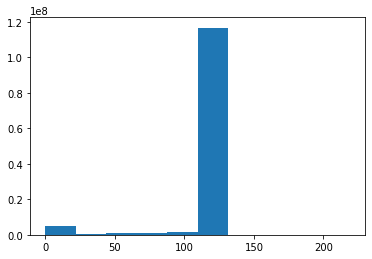

In [8]:
#plot tiles as histogram

# sns.histplot(data=A10_1map, x='Tile Lengths')
plt.hist(map1['T Len'])
# plt.xlim([100, 125])
plt.show()

In [9]:
#look into specifics of who has what length...
map1[map1["T Len"] == 120].shape[0]

81274594

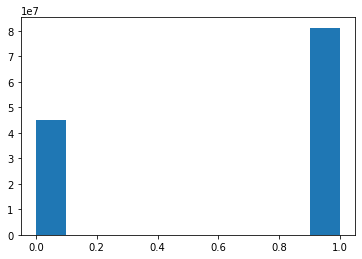

In [10]:
#plot tile qual as histogram

plt.hist(map1['T Qual'])

plt.show()

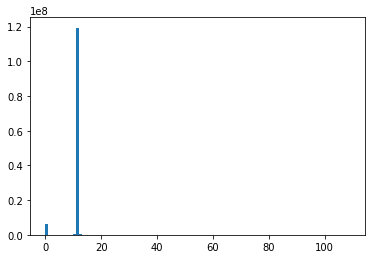

In [11]:
# plot AD BC len

plt.hist(map1['A Len'], bins=100)
plt.show()

In [12]:
#look into specifics of who has what length...
map1[map1["A Qual"] == 1].shape[0]

119346572

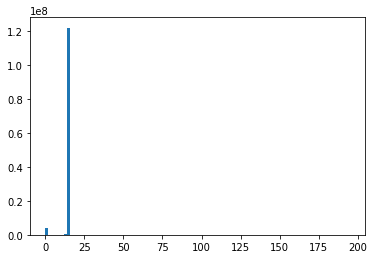

In [13]:
# plot RPTR BC len

plt.hist(map1['R Len'], bins=100)
plt.show()

In [14]:
#look into specifics of who has what length...
map1[map1["R Qual"] == 1].shape[0]

121663257

In [15]:
map1[map1["Designed"] == 1].shape[0]

74028720

In [16]:
color_conditions = {
    'Designed_Not120': (map1['Designed'] & ~map1['T Qual']),
    'NotDesigned_Yes120': (~map1['Designed'] & map1['T Qual']),
    'true_both': (map1['Designed'] & map1['T Qual']),
    'false_both': (~map1['Designed'] & ~map1['T Qual'])
}

In [17]:
colors = {
    'Designed_Not120': 'blue',
    'NotDesigned_Yes120': 'orange',
    'true_both': 'green',
    'false_both': 'red'
}

In [18]:
color_counts = {category: condition.sum() for category, condition in color_conditions.items()}

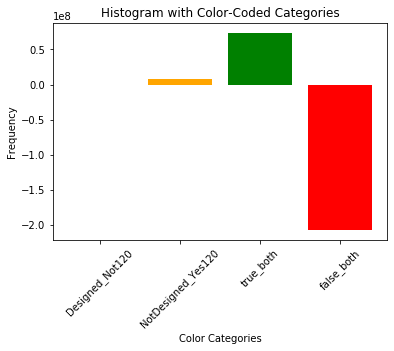

In [19]:
plt.bar(color_counts.keys(), color_counts.values(), color=[colors[c] for c in color_counts.keys()])
plt.xlabel('Color Categories')
plt.ylabel('Frequency')
plt.title('Histogram with Color-Coded Categories')
plt.xticks(rotation=45)
plt.show()

Observations from above: Most reads have a tile, and nearly all the reads have a legible barcode. Most of the tiles that are legible are also designed


Now we want to know:
1. Coverage? ie Each tile shows up how many times? -- look at tiles ==120 bp
2. How many of those tiles are designed?
3. Coverage of tile-bc-bc combos??

### Filtering out reads that either do not have the consensus sequences to find the tiles/BCs OR have tiles/BCs of unexpected lengths

map2 is the df with only tiles that match designed and where BC lengths are as expected. All length and quality columns are dropped, as well as the column that stored the full read strings.

In [20]:

#Replace all 0s in map1 with NaN to filter out any Qual=0 reads
map1_nans = map1.replace(0, np.nan)
# map1_nans.head()
map2 = map1_nans.dropna().reset_index()
#get rid of some now useless columns
clabels = ['index','Reads', 'T Len','T Qual', 'Designed', 'A Len','A Qual', 'R Len','R Qual']
map2 = map2.drop(clabels, axis = 1)


# how many reads are lost? rc = readcount
rcmap1 = map1.shape[0]
rcmap2 = map2.shape[0]
diffpct = ((rcmap1 - rcmap2) / rcmap1)*100
print("% Reads lost:")
print(diffpct)

map2.head()

% Reads lost:
44.056691395586675


,Tiles,AD BCs,RPTR BCs
0,CATACTCCATCTACTGATGCTTTGATTAATCCAGCTGCTTTGATGT...,CAAAAGTACAG,TAGGCGCTTGTACA
1,TCTCAATCTTCTTGGTTGCCATCTTCTTCTCCATCTTTGCCAGCTC...,TACGCGGAATC,ATTGTTGTTACACG
2,AATCATTTGCCACAACAATGTACTCCATCTTCTGTTCAATCTCCAC...,ATCCGTACAGC,GTTTTACCTTTGTC
3,AAATCATTTGAAGCTAGGATTCCAAGAAGACATATGGTTATGACTT...,CAGAGATATCA,TAAAGAGGATCTAA
4,AATGGTATGGACTTCTCTGCTGCTGAAGCATTTACTAGAATGAAGA...,GGAGTGTTCAT,TCGAACCATCCTGA


### Coverage
map3 is a df with tiles, BCs, and combos of tiles and BCs

In [21]:
map3 = map2.copy()
map3.head()

,Tiles,AD BCs,RPTR BCs
0,CATACTCCATCTACTGATGCTTTGATTAATCCAGCTGCTTTGATGT...,CAAAAGTACAG,TAGGCGCTTGTACA
1,TCTCAATCTTCTTGGTTGCCATCTTCTTCTCCATCTTTGCCAGCTC...,TACGCGGAATC,ATTGTTGTTACACG
2,AATCATTTGCCACAACAATGTACTCCATCTTCTGTTCAATCTCCAC...,ATCCGTACAGC,GTTTTACCTTTGTC
3,AAATCATTTGAAGCTAGGATTCCAAGAAGACATATGGTTATGACTT...,CAGAGATATCA,TAAAGAGGATCTAA
4,AATGGTATGGACTTCTCTGCTGCTGAAGCATTTACTAGAATGAAGA...,GGAGTGTTCAT,TCGAACCATCCTGA


In [22]:
adcol = map3['AD BCs'].copy()
rpcol = map3['RPTR BCs'].copy()

map3['Cat'] = map3['Tiles'].str.cat(adcol, sep="-").str.cat(rpcol, sep="-")
map3['BC Pairs'] = map3['AD BCs'].str.cat(rpcol, sep='-')

map3.head()

,Tiles,AD BCs,RPTR BCs,Cat,BC Pairs
0,CATACTCCATCTACTGATGCTTTGATTAATCCAGCTGCTTTGATGT...,CAAAAGTACAG,TAGGCGCTTGTACA,CATACTCCATCTACTGATGCTTTGATTAATCCAGCTGCTTTGATGT...,CAAAAGTACAG-TAGGCGCTTGTACA
1,TCTCAATCTTCTTGGTTGCCATCTTCTTCTCCATCTTTGCCAGCTC...,TACGCGGAATC,ATTGTTGTTACACG,TCTCAATCTTCTTGGTTGCCATCTTCTTCTCCATCTTTGCCAGCTC...,TACGCGGAATC-ATTGTTGTTACACG
2,AATCATTTGCCACAACAATGTACTCCATCTTCTGTTCAATCTCCAC...,ATCCGTACAGC,GTTTTACCTTTGTC,AATCATTTGCCACAACAATGTACTCCATCTTCTGTTCAATCTCCAC...,ATCCGTACAGC-GTTTTACCTTTGTC
3,AAATCATTTGAAGCTAGGATTCCAAGAAGACATATGGTTATGACTT...,CAGAGATATCA,TAAAGAGGATCTAA,AAATCATTTGAAGCTAGGATTCCAAGAAGACATATGGTTATGACTT...,CAGAGATATCA-TAAAGAGGATCTAA
4,AATGGTATGGACTTCTCTGCTGCTGAAGCATTTACTAGAATGAAGA...,GGAGTGTTCAT,TCGAACCATCCTGA,AATGGTATGGACTTCTCTGCTGCTGAAGCATTTACTAGAATGAAGA...,GGAGTGTTCAT-TCGAACCATCCTGA


In [23]:
# Now make a df that tells me the frequency of each tile-bc-bc combo

tbbcov = map3['Cat'].value_counts().to_frame().reset_index()
print('number unique tbb combos:')
print(tbbcov.shape[0]) 
tbbcov.head(10)

number unique tbb combos:
22769597


,index,Cat
0,TTCTCTCATGATCCATCTCCAATGTTGTCTGATGACTTTGGTTCTG...,54
1,TCTTTGGCTACTTCTGCTATTGAAGTTCCAACTGAAGATTCTACTG...,52
2,GAATTTGGTCCAATCTTGTCTTTGGATGATGGTGCTACTGCTGGTG...,51
3,TTGTTTGATAGATCTCCATCTGCTAGATCTGCTCCAAATTTGTCTT...,50
4,CAGAAACAGAAATCTATCTTGAGACCATCTGCTAGATTGAGAGGTG...,48
5,GTCTTGTATGATCAACCAGCTCCACCAAGAAGAGCTCCATCTGCTC...,47
6,GTTCCATTGTTCTCTCATGGTACTTCTGCTCAACAAACTCCATCTG...,46
7,GACCCATCTAGATGGGCTGCTACTGGTCAACAACCAGCTCCAACTC...,44
8,GATGGTGGTGCTACTACTGAAGCTGCATTTGCTTCTCCAGCTAATC...,44
9,CAACCAGAATTGATTCAACCAGTTCAACAAACTGTTCAACCAACTG...,44


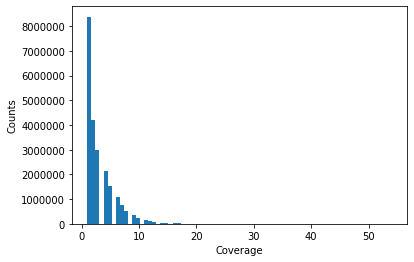

In [24]:
# plot tbb coverage on histogram

plt.figure()
plt.hist(tbbcov['Cat'],  bins=75)
plt.xlabel('Coverage')
plt.ylabel('Counts')
plt.show()

In [25]:
tbbcov.describe()

,Cat
count,2.276960e+07
mean,3.105442e+00
std,2.670241e+00
min,1.000000e+00
25%,1.000000e+00
50%,2.000000e+00
75%,4.000000e+00
max,5.400000e+01


In [26]:
# Tile coverage
tcov = map2['Tiles'].value_counts().to_frame().reset_index()
print ('# unique Tiles:')
print(tcov.shape[0])
tcov.head()

# unique Tiles:
20695


,index,Tiles
0,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,14424
1,GATGTTACTCCAGCTTCTCCAATGATTAGAACTACTTCTTCTAGAG...,9573
2,TCTACTGCTCCACCAACTGATGTTTCTTTGGGTGATGAATTGCATT...,9484
3,TTGCAACAGAAACATAGATTGGCTCAAATTCAAGCTTCTGGTTCTC...,9282
4,TCTGCTGATTATTCTGGTTTGCAATCTGATTATTCTCCATTGACTG...,9090


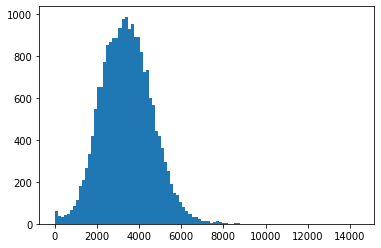

In [27]:
# plot tile coverage 
plt.hist(tcov['Tiles'], bins=100)
plt.show()

In [28]:
#ad bc coverage
abcov = map3['AD BCs'].value_counts().to_frame().reset_index()
print(abcov.shape) # number unique ad bcs:
abcov.head()

(4063749, 2)


,index,AD BCs
0,TCCCCCCCCCC,898
1,CCCCGCCCCCC,774
2,CCCCCTCCCCC,719
3,TCCCCTCCCCC,714
4,CCCCTCCCCCC,704


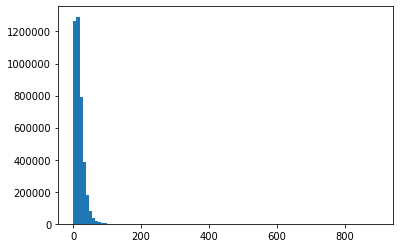

In [29]:
# plot ad bc coverage 
plt.hist(abcov['AD BCs'], bins=100)
plt.show()

In [30]:
#rptr bc coverage
rbcov = map3['RPTR BCs'].value_counts().to_frame().reset_index()
print(rbcov.shape) # number unique ad bcs:
rbcov.head()

(17998135, 2)


,index,RPTR BCs
0,CTATACTACTAGTA,59
1,GGGTTGTACATACA,54
2,GCCGCGCCCAGGGC,52
3,AGACGAGGGATGGG,51
4,CACTCCGCCGCGCC,50


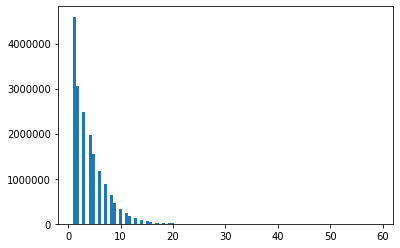

In [31]:
# plot rptr bc coverage 
plt.hist(rbcov['RPTR BCs'], bins=100)
plt.show()

In [ ]:
map3.to_csv('A10_2_tbcmapDEEP.csv')